In [1]:
import numpy as np
from scipy.stats import norm, expon, uniform
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [6]:
def hmc_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
                delta: float = 0.3,
                L: float = 20,
                x0: np.array = np.array([0,6]).T
               ) -> None:
    """
    A toy application of HMC to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param delta step size for leap-frog
    :param L # of steps for leap-frog to take per sample
    :param x0 starting position
    :return None
    """
   
    delta = 0.3 # step size, keeping it fixed to break it
    n_samples = 10000
    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x) # potential
    dU = lambda x: np.dot(x.T, np.linalg.inv(M)) # gradient
    K = lambda p: np.dot(p.T, p) * 0.5 # Kinetic Energy

    x = [x0]

    t = 1
    accepted = 0 # keep track of acceptance rate
    for _ in range(n_samples):
        # sampling loop
        p0 = norm.rvs(size = 2).T # sample momentum

        # start SV steps
        pStar = p0 - delta / 2 * dU(x[-1]).T

        xStar = x[-1] + delta * pStar

        for j in range(L-1):
            pStar = pStar - delta * dU(xStar).T

            xStar = xStar + delta * pStar

        pStar = pStar - delta / 2 * dU(xStar).T

        U0 = U(x[-1])
        UStar = U(xStar)

        K0 = K(p0)
        KStar = K(pStar)
        # acceptance probability, difference in initial and final energy/Hamiltonian
        alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))

        u = uniform.rvs()
        if u < alpha:
            x.append(xStar)
            accepted += 1
        else:
            x.append(x[-1])

    print(f"HMC Acceptance Rate: {accepted / n_samples:.3f}")
    x = np.array(x)

    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(x[50:,0], x[50:,1], '.', color='blue')
    _ = plt.plot(x[:50,0], x[:50,1], 'o-', color='red', label = "First 50 samples")
    plt.xlim([-4,4])
    plt.legend()
    title_str = 'Hamiltonian Monte Carlo\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)

    

def mh_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
               x0: np.array = np.array([0,6]).T
              ) -> None:
    """
    A toy application of Metropolis-Hastings to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param x0 starting position
    :return None
    """
    n_samples = 10000

    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x)
    x0 = np.array([0,6]).T
    y = [x0]

    accepted = 0
    for _ in range(n_samples):

        yStar = y[-1] + norm.rvs(size=2, scale=0.7)
        U0 = U(y[-1])
        UStar = U(yStar)

        alpha = min(1, np.exp((U0)-(UStar)))

        u = uniform.rvs()
        if u < alpha:
            y.append(yStar)
            accepted += 1
        else:
            y.append(y[-1])
            
    print(f"Metropolis-Hastings Acceptance Rate: {accepted / n_samples}")
    y = np.array(y)


    
    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(y[50:,0], y[50:,1], '.', color = 'blue')
    _ = plt.plot(y[:50,0], y[:50,1], 'o-', color = 'red', label = "First 50 samples")
    plt.xlim([-4, 4])
    plt.legend()
    title_str = 'Metropolis-Hastings\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)
    

def compare_and_plot(M: np.array = np.array([[1,0],[0,1]]),
                     delta: float = 0.3,
                     L: float = 20,
                     x0: np.array = np.array([0,6]).T
                    ) -> None:
    mh_gauss2d(M, x0 = x0)
    hmc_gauss2d(M, delta = delta, L = L, x0 = x0)

Metropolis-Hastings Acceptance Rate: 0.5505
HMC Acceptance Rate: 0.789


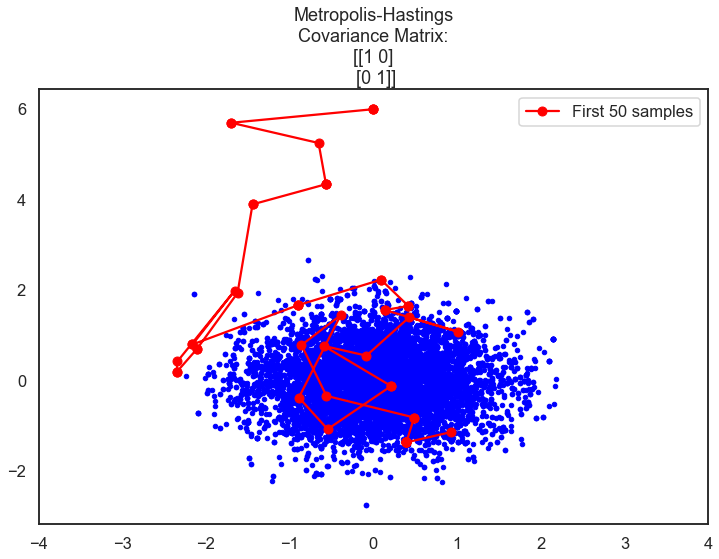

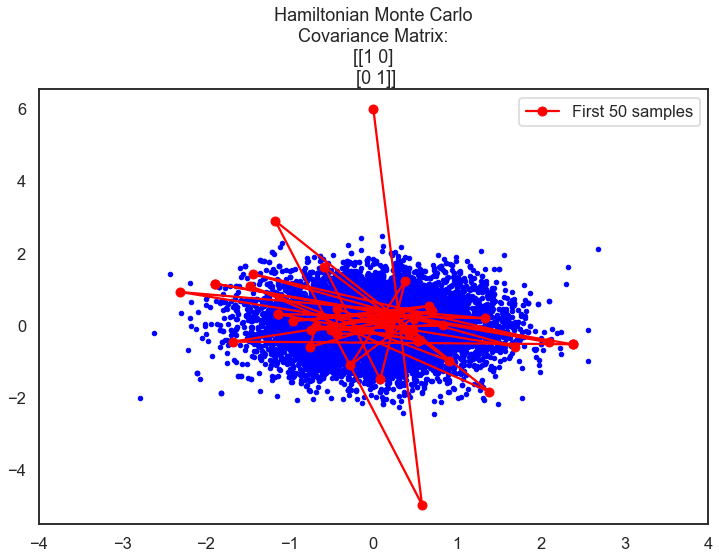

In [8]:
compare_and_plot(L = 50)

In [86]:
def stormer_verlet(q, p ,h ,n , dU, dK):
    Q = [q]
    P = [p]
    for i in range(n):
        p = P[i] - (h / 2) * dU(Q[i])
        Q.append(Q[i] + h * dK(p))
        P.append(p - (h / 2) * dU(Q[i+1]))
    return np.array(Q), np.array(P)

In [3]:
K = lambda p: np.dot(p,p) / 2
dK = lambda p: p
U = lambda q: -1 / (np.dot(q,q) ** 0.5)
dU = lambda q: q / (np.dot(q,q) ** 1.5)
H = lambda q,p: K(p) + U(q)

def initial_conditions(e):
    q0 = np.array([1 - e, 0])
    p0 = np.array([0, np.sqrt((1 + e) / (1 - e))])
    return q0, p0

def energy(Q, P, H):
    hamiltonian = []
    for q, p in zip(Q,P):
        hamiltonian.append(H(q,p))
    return hamiltonian

CPU times: user 3min 20s, sys: 2.25 s, total: 3min 22s
Wall time: 3min 23s


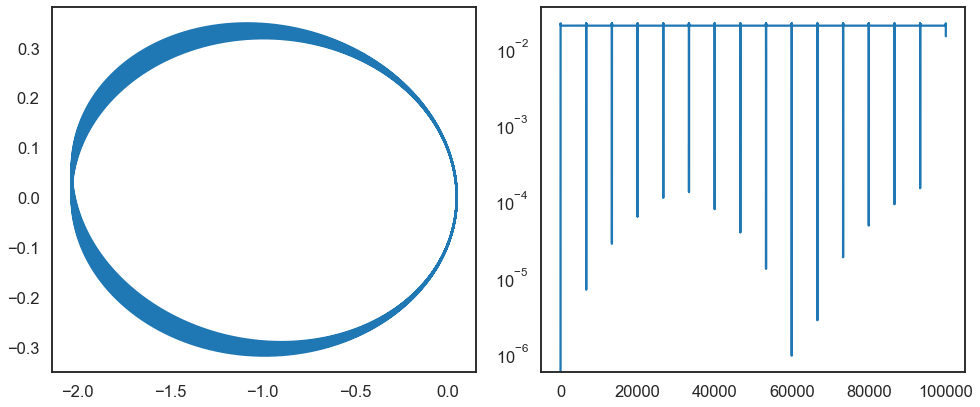

In [182]:
%%time
n = 100000
h = 0.001
e = 0.95
q0,p0 = initial_conditions(e)
Q, P = stormer_verlet(q0, p0, h, n, dU, dK)
energy_error = np.abs(energy(Q, P, H) - H(q0,p0))
fig, axs = plt.subplots(1,2, figsize = (14,6))
axs[0].plot(Q[:,0], Q[:,1])
axs[1].plot(np.arange(n+1),energy_error)
axs[1].set_yscale("log")
plt.tight_layout()

In [175]:
def adap_stormer_verlet(q, p ,h ,n , dU, dK, G):
    max_time = h * n
    total_time = 0
    Q = [q]
    P = [p]
    T = [1 - (h / 2) * G(q,p)]
    for i in range(n):
        T.append(T[i] + h * G(Q[i],P[i]))
        p = P[i] - (h / 2) * dU(Q[i]) / T[i + 1]
        Q.append(Q[i] + h * dK(p) / T[i + 1])
        P.append(p - (h / 2) * dU(Q[i+1]) / T[i + 1])
        total_time += h / T[i + 1]
        if total_time >= max_time:
            break
    return np.array(Q), np.array(P), T

In [4]:
G = lambda q,p: (-3 / 2) * np.dot(q,p) / np.dot(q,q)

CPU times: user 705 ms, sys: 133 ms, total: 838 ms
Wall time: 509 ms


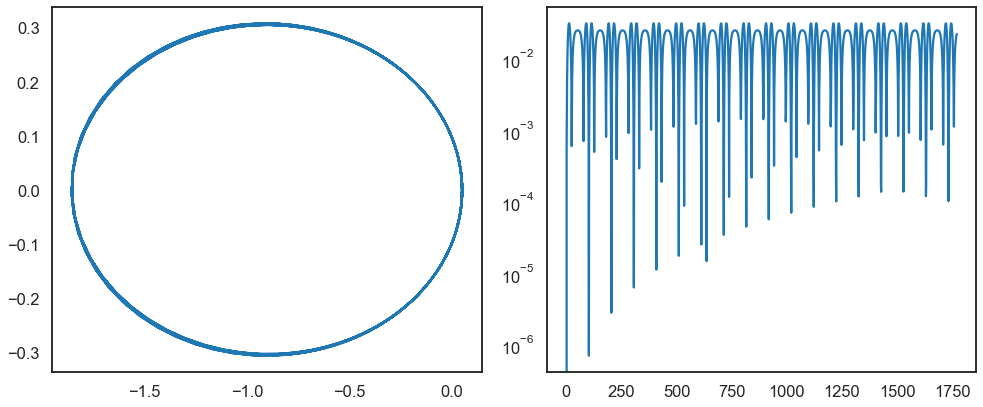

In [183]:
%%time
n = 100000
h = 0.001
e = 0.95
q0,p0 = initial_conditions(e)
Q, P, T = adap_stormer_verlet(q0, p0, h, n, dU, dK, G)
energy_error = np.abs(energy(Q, P, H)-H(q0,p0))
fig, axs = plt.subplots(1,2, figsize = (14,6))
axs[0].plot(Q[:,0], Q[:,1])
axs[1].plot(np.arange(Q.shape[0]),energy_error)
axs[1].set_yscale("log")
plt.tight_layout()

In [5]:
def adap_hmc_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
                delta: float = 0.3,
                L: float = 20,
                x0: np.array = np.array([0,6]).T
               ) -> None:
    """
    A toy application of HMC to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param delta step size for leap-frog
    :param L # of steps for leap-frog to take per sample
    :param x0 starting position
    :return None
    """
   
    delta = 0.3 # step size, keeping it fixed to break it
    n_samples = 10000
    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x) # potential
    dU = lambda x: np.dot(x.T, np.linalg.inv(M)) # gradient
    K = lambda p: np.dot(p.T, p) * 0.5 # Kinetic Energy
    dK = lambda p: p

    x = [x0]

    t = 1
    accepted = 0 # keep track of acceptance rate
    
    max_time = delta * L
    
    for _ in range(n_samples):
        # sampling loop
        p0 = norm.rvs(size = 2).T # sample momentum

        total_time = 0
        # initial variable step size divisor
        tStar = 1 - (delta / 2) * G(x[-1], p0)
        # start SV steps
        pStar = p0 - (delta / 2) * dU(x[-1]).T / tStar

        xStar = x[-1] + delta * pStar / tStar
        
        total_time += delta / tStar
        
        for j in range(L-1):
            pStar = pStar - delta * dU(xStar).T / tStar

            xStar = xStar + delta * pStar / tStar
            
            total_time += delta / tStar
            if total_time >= max_time:
                break

        pStar = pStar - (delta / 2) * dU(xStar).T / tStar

        U0 = U(x[-1])
        UStar = U(xStar)

        K0 = K(p0)
        KStar = K(pStar)
        # acceptance probability, difference in initial and final energy/Hamiltonian
        alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))

        u = uniform.rvs()
        if u < alpha:
            x.append(xStar)
            accepted += 1
        else:
            x.append(x[-1])

    print(f"HMC Acceptance Rate: {accepted / n_samples:.3f}")
    x = np.array(x)

    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(x[50:,0], x[50:,1], '.', color='blue')
    _ = plt.plot(x[:50,0], x[:50,1], 'o-', color='red', label = "First 50 samples")
    plt.xlim([-4,4])
    plt.legend()
    title_str = 'Hamiltonian Monte Carlo\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)

In [7]:
def compare_and_plot(M: np.array = np.array([[1,0],[0,1]]),
                     delta: float = 0.3,
                     L: float = 20,
                     x0: np.array = np.array([0,6]).T
                    ) -> None:
    %time
    mh_gauss2d(M, x0 = x0)
    %time
    hmc_gauss2d(M, delta = delta, L = L, x0 = x0)
    %time
    adap_hmc_gauss2d(M, delta = delta, L = L, x0 = x0)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs
Metropolis-Hastings Acceptance Rate: 0.5505
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
HMC Acceptance Rate: 0.789
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs
HMC Acceptance Rate: 0.759


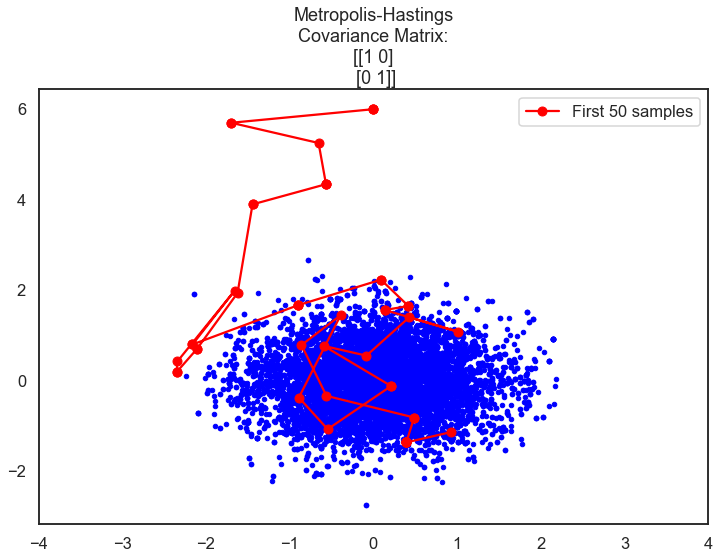

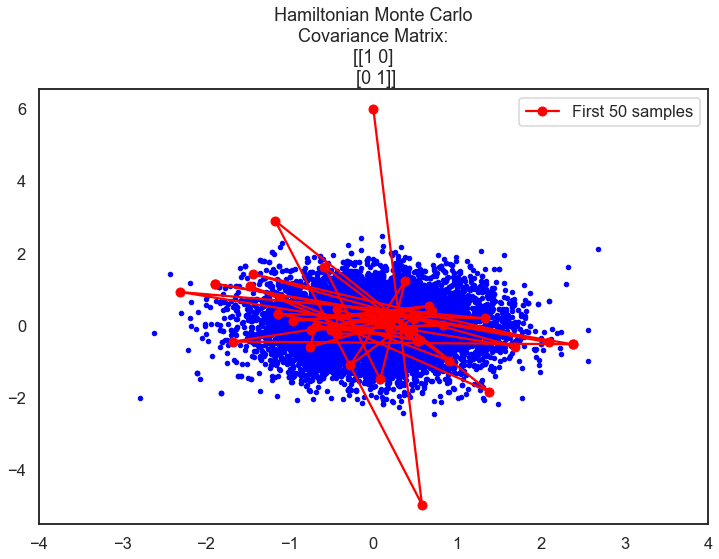

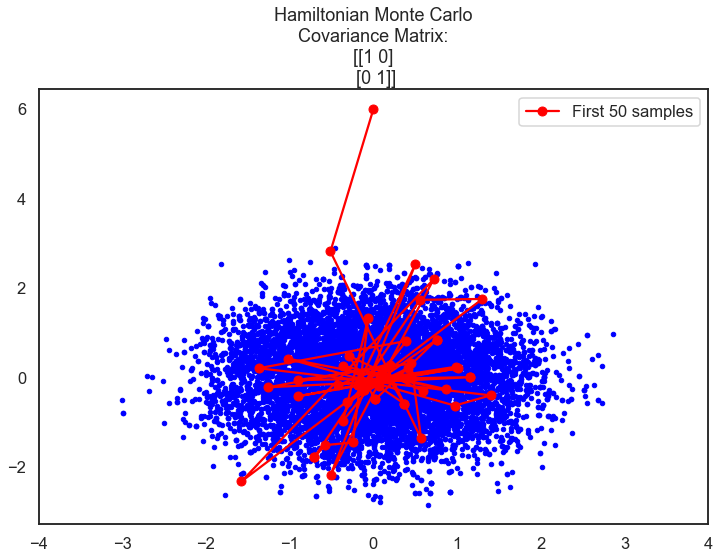

In [8]:
compare_and_plot(L = 50)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs
Metropolis-Hastings Acceptance Rate: 0.3811
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
HMC Acceptance Rate: 0.824
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
HMC Acceptance Rate: 0.735


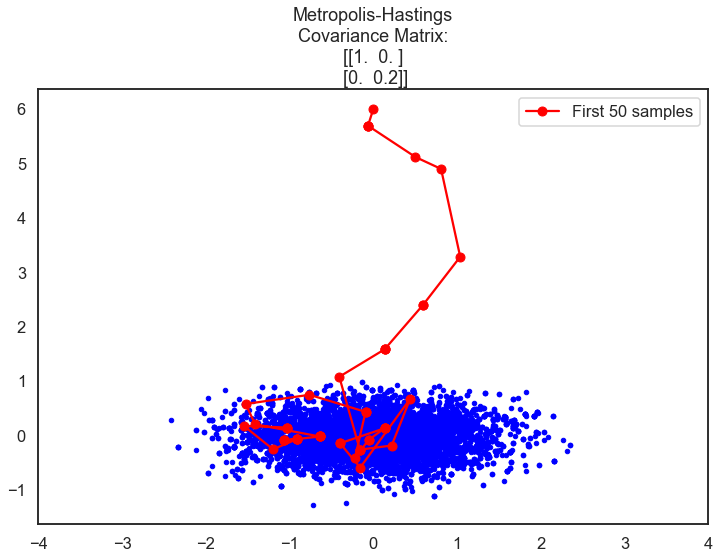

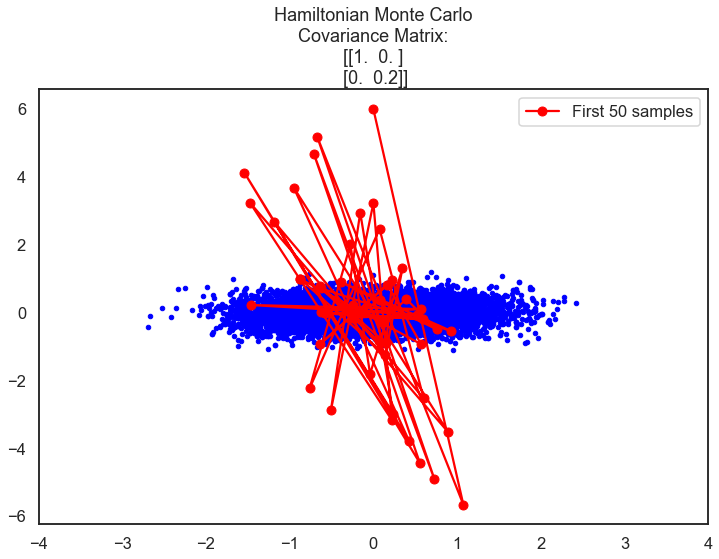

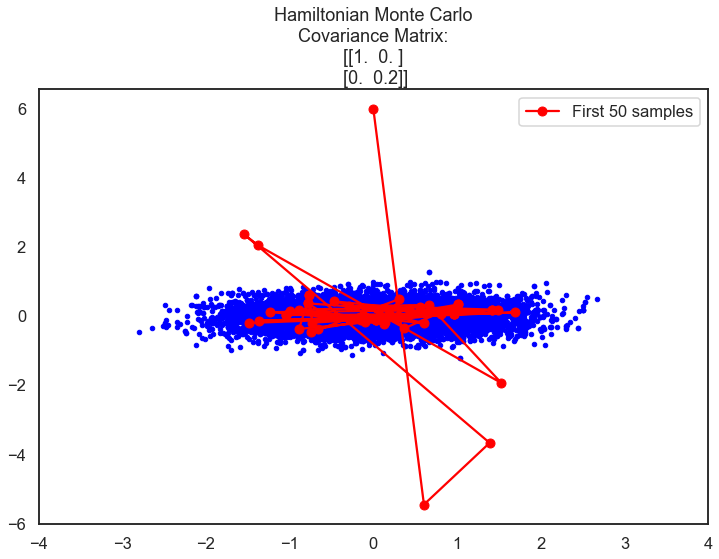

In [9]:
M = np.array([[1,0],[0,0.2]])
compare_and_plot(M = M, L = 50)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
Metropolis-Hastings Acceptance Rate: 0.2894
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs
HMC Acceptance Rate: 0.717
CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs
HMC Acceptance Rate: 0.670


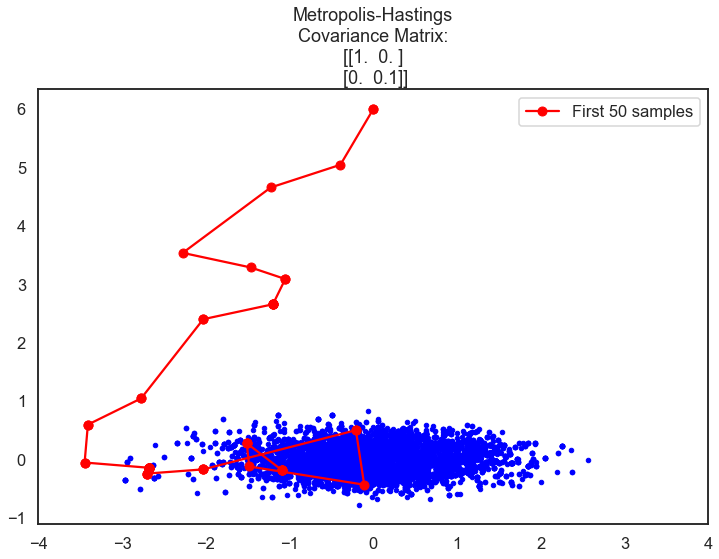

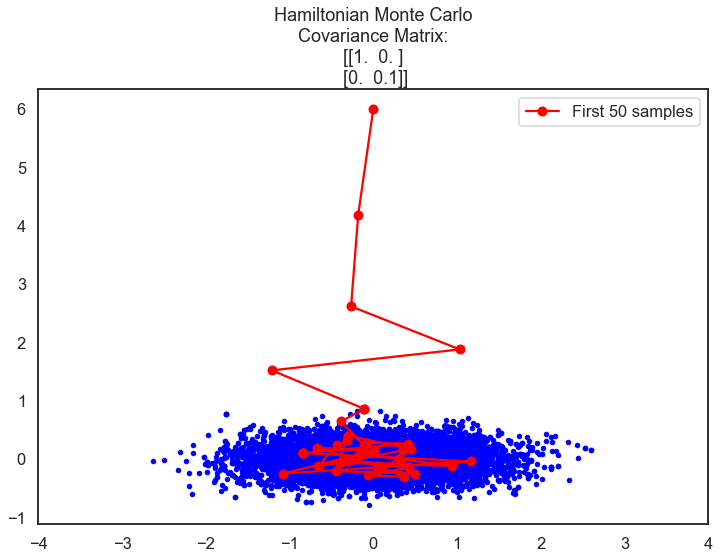

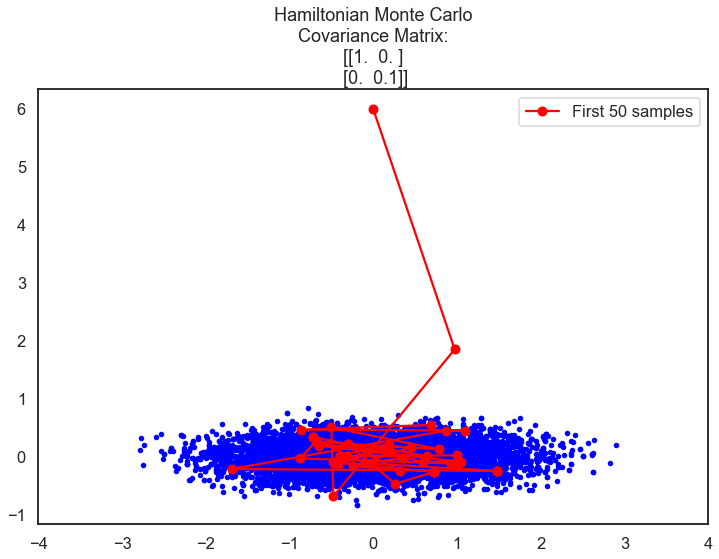

In [10]:
M = np.array([[1,0],[0,0.1]])
compare_and_plot(M = M, L = 50)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
Metropolis-Hastings Acceptance Rate: 0.3131
CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs
HMC Acceptance Rate: 0.650
CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in add


HMC Acceptance Rate: 0.857


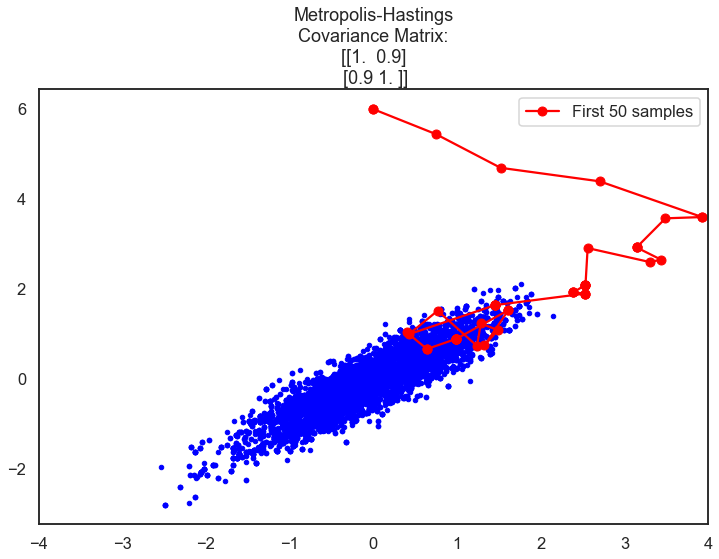

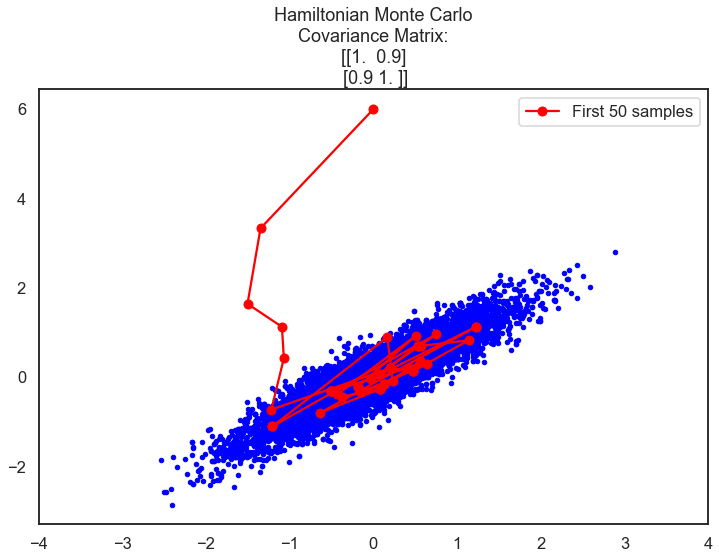

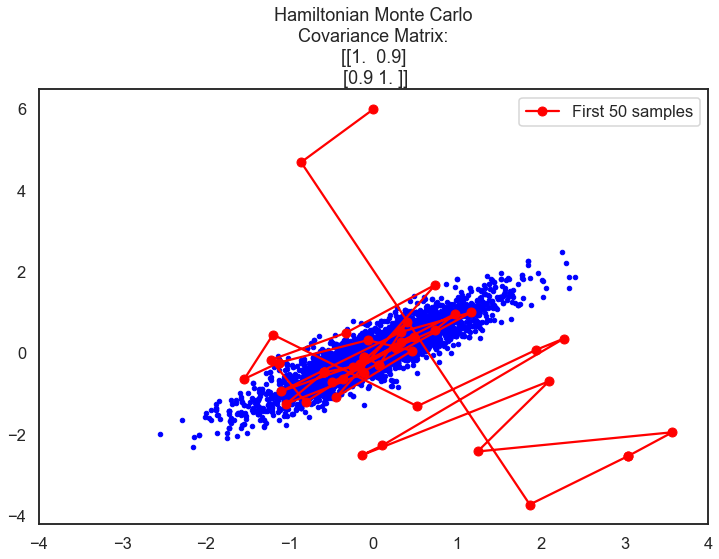

In [11]:
M = np.array([[1,0.9],[0.9,1]])
compare_and_plot(M = M, L = 50)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
Metropolis-Hastings Acceptance Rate: 0.2333
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
HMC Acceptance Rate: 0.541
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in true_divide
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in add


HMC Acceptance Rate: 0.612


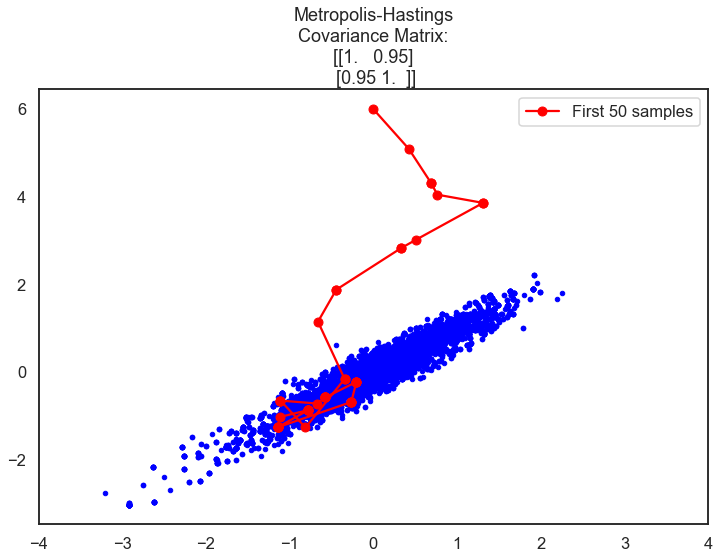

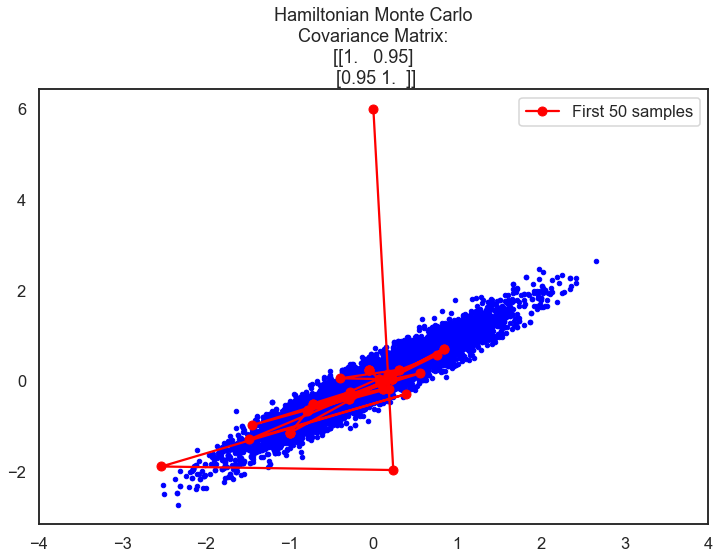

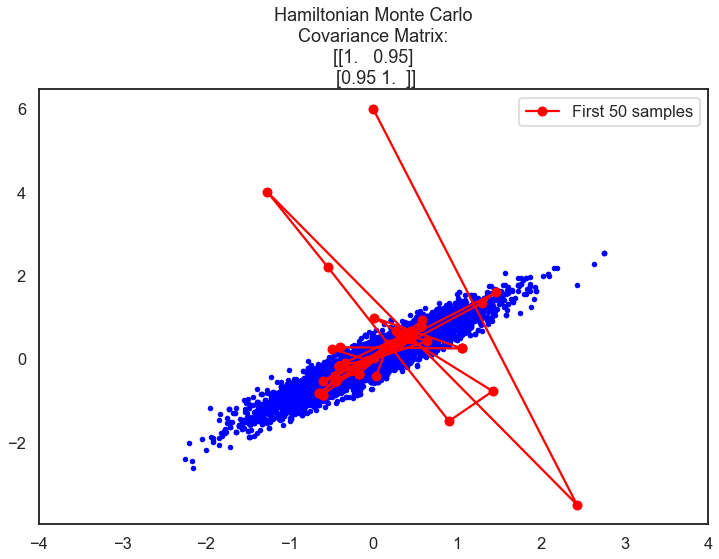

In [12]:
M = np.array([[1,0.95],[0.95,1]])
compare_and_plot(M = M, L = 50)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
Metropolis-Hastings Acceptance Rate: 0.1521
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs
HMC Acceptance Rate: 0.000
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
HMC Acceptance Rate: 0.001


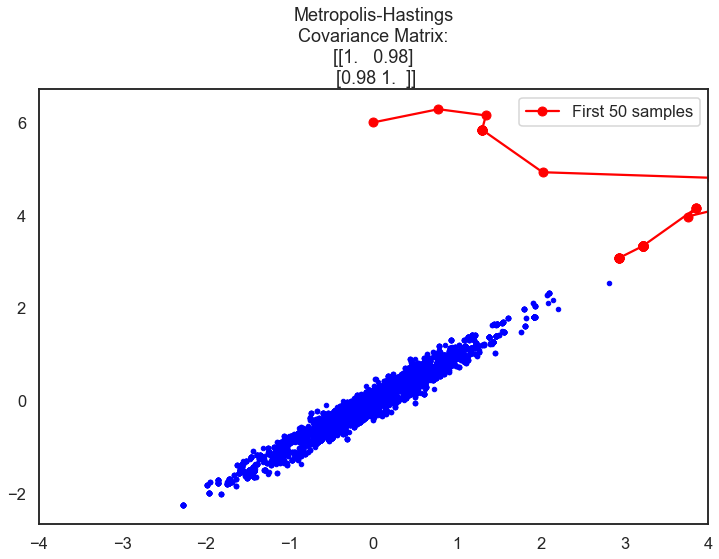

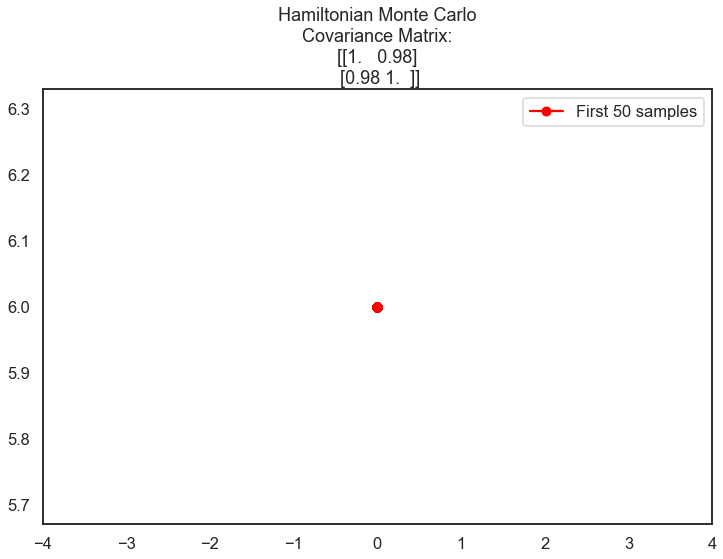

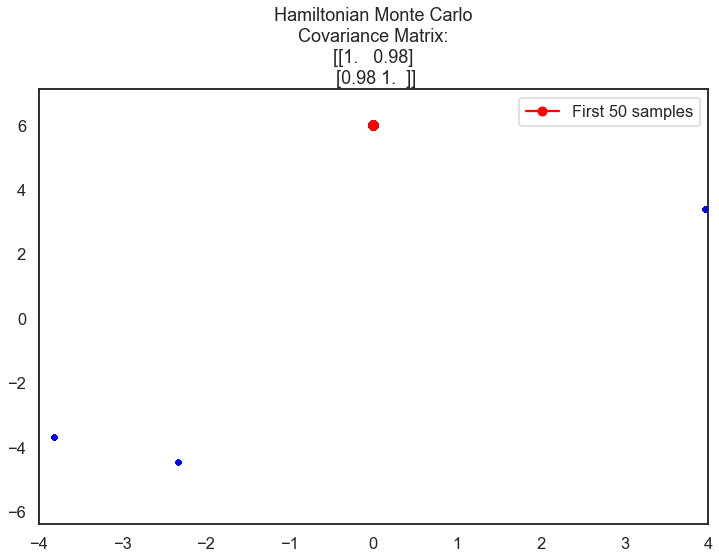

In [13]:
M = np.array([[1,0.98],[0.98,1]])
compare_and_plot(M = M, L = 50)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 17.9 µs
Metropolis-Hastings Acceptance Rate: 0.1574
CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.81 µs
HMC Acceptance Rate: 0.000
CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.77 µs
HMC Acceptance Rate: 0.013


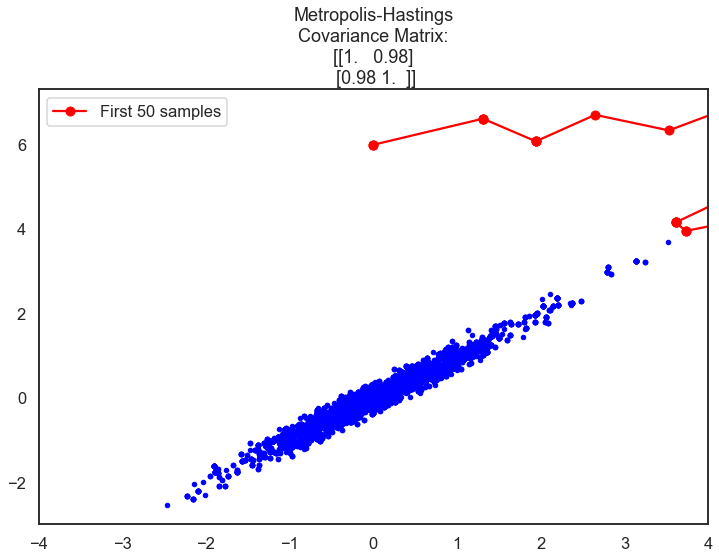

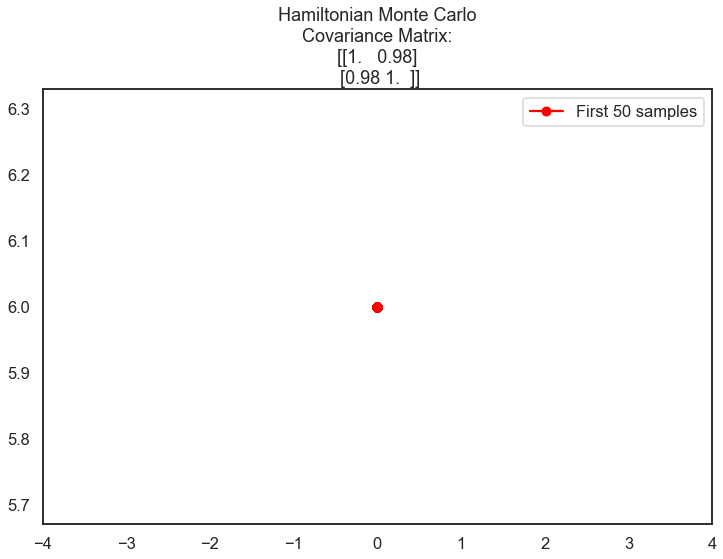

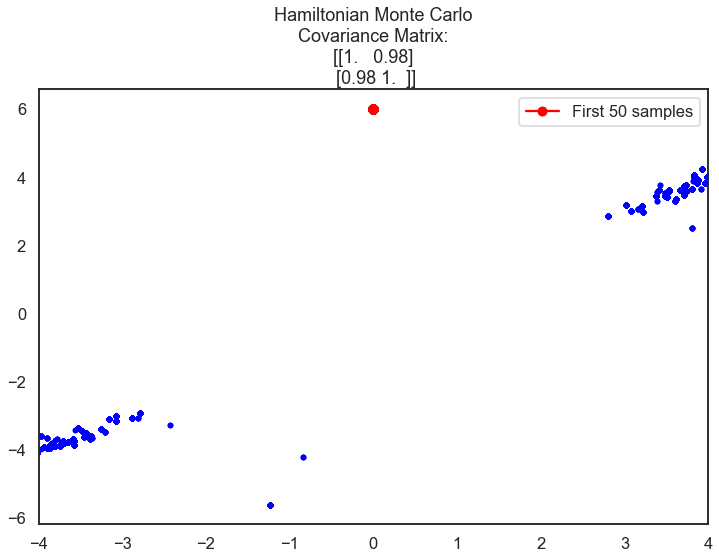

In [15]:
compare_and_plot(M = M, L = 20, delta = 0.05)